# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [1]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [2]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"hshshsbhsyugsgygys","key":"860ba3e66aad4e0176afc0d5c2231839"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists


In [3]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [5]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [6]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset already exists at chest_xray_dataset. Skipping download.


In [7]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Re-split dataset already exists at chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [8]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

In [9]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
#Analysis 1
# Print class distribution
for split in splits:
    total = sum(stats[split].values())
    print(f"\n{split.upper()} SET:")
    for cls in classes:
        count = stats[split][cls]
        print(f"  {cls}: {count} ({count/total:.2%})")



TRAIN SET:
  NORMAL: 1266 (27.03%)
  PNEUMONIA: 3418 (72.97%)

VAL SET:
  NORMAL: 158 (27.01%)
  PNEUMONIA: 427 (72.99%)

TEST SET:
  NORMAL: 159 (27.09%)
  PNEUMONIA: 428 (72.91%)


**Analysis 1**

Label distribution analysis:
The dataset is significantly imbalanced, with substantially more PNEUMONIA samples than NORMAL across all splits. This imbalance may bias the classifier towards predicting the majority class, potentially inflating accuracy while reducing sensitivity to NORMAL cases.

Impact on training:
To mitigate this, techniques such as data augmentation, or alternative evaluation metrics (e.g. precision, recall, F1-score) should be considered rather than relying solely on accuracy.

In [10]:
# Analysis 2

sample_images = []

for cls in classes:
    sample_path = os.path.join(new_dataset_path, 'train', cls)
    img_name = os.listdir(sample_path)[0]
    img = Image.open(os.path.join(sample_path, img_name))
    sample_images.append((cls, img))

for cls, img in sample_images:
    img_array = np.array(img)
    print(f"\nClass: {cls}")
    print("  Image size:", img.size)
    print("  Array shape:", img_array.shape)
    print("  Pixel range:", img_array.min(), "to", img_array.max())



Class: NORMAL
  Image size: (1492, 1024)
  Array shape: (1024, 1492)
  Pixel range: 0 to 255

Class: PNEUMONIA
  Image size: (800, 472)
  Array shape: (472, 800)
  Pixel range: 0 to 255


**Analysis 2**

Input feature analysis:
The dataset contains chest X-ray images with varying spatial resolutions and inconsistent channel formats. Some images are stored as single-channel grayscale images, while others are stored as three-channel RGB images. Pixel intensity ranges also differ between samples.

Impact on training:
These inconsistencies require preprocessing steps such as resizing images to a fixed resolution, standardising channel format, and normalising pixel values. Without this, the model would be unable to process the inputs consistently and training stability would be negatively affected.

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [11]:
dataset_path = "chest_xray_dataset_new_split"
batch_size =12

In [12]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.images = []  # list of (image_path, label)

        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, self.split, cls)
            if not os.path.isdir(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")

            for fname in os.listdir(cls_dir):
                # basic filtering (helps avoid hidden/system files)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(cls_dir, fname), self.class_to_idx[cls]))

        # optional: stable ordering (good for reproducibility)
        self.images.sort(key=lambda x: x[0])


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        img_path, label = self.images[idx]

        # Convert everything to 3-channel RGB to standardise channel shape
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [13]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [14]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
# Create datasets
train_dataset = ChestXrayDataset(new_dataset_path, split='train', transform=train_transform)
val_dataset   = ChestXrayDataset(new_dataset_path, split='val',   transform=val_test_transform)
test_dataset  = ChestXrayDataset(new_dataset_path, split='test',  transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


# -------------------------
# Print dataset sizes
# -------------------------
print("Dataset sizes:")
print("  Train:", len(train_dataset))
print("  Val  :", len(val_dataset))
print("  Test :", len(test_dataset))

# -------------------------
# Print batch shapes
# -------------------------
x, y = next(iter(train_loader))
print("\nOne training batch:")
print("  Images shape:", x.shape)   # (B, 3, 224, 224)
print("  Labels shape:", y.shape)   # (B,)
print("  Labels dtype:", y.dtype)
print("  Example labels:", y[:10].tolist())

Dataset sizes:
  Train: 4684
  Val  : 585
  Test : 587

One training batch:
  Images shape: torch.Size([12, 1, 128, 128])
  Labels shape: torch.Size([12])
  Labels dtype: torch.int64
  Example labels: [1, 1, 1, 1, 0, 0, 1, 1, 1, 1]


**Design choices:**

All images were resized to a fixed resolution of 128×128 pixels to ensure consistent input dimensions and reduce computational cost. Images were converted to single-channel grayscale to remove redundant colour information that is not clinically relevant for chest X-ray interpretation and to simplify the model input. Data augmentation techniques, including random horizontal flipping and small random rotations up to 10 degrees, were applied exclusively to the training set to improve robustness to variations in patient orientation and positioning, while avoiding information leakage into validation and test data. Pixel intensities were normalised using a fixed mean and standard deviation to stabilise optimisation and improve convergence during training. The validation and test transforms excluded augmentation to ensure that evaluation metrics reflect true model performance on unaltered data.

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [15]:
num_epochs = 10
use_wandb = False  # Set to True if you want to use wandb
lr = 1e-3

In [16]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
  def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B,16,1,1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

  def forward(self, x):
      x = self.features(x)
      x = self.pool(x)
      return self.classifier(x)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [17]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    preds = outputs.argmax(dim=1)
    class_acc = {}
    for cls in [0, 1]:
        mask = (labels == cls)
        if mask.sum().item() == 0:
            class_acc[cls] = float('nan')
        else:
            class_acc[cls] = (preds[mask] == labels[mask]).float().mean().item()
    return class_acc


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [18]:
def update_confusion(cm, preds, labels):
    for p, t in zip(preds.view(-1), labels.view(-1)):
        cm[t.long(), p.long()] += 1
    return cm

def class_accuracy_from_cm(cm):
    # row = true class, col = predicted class
    accs = {}
    for c in range(cm.shape[0]):
        denom = cm[c].sum().item()
        accs[c] = (cm[c, c].item() / denom) if denom > 0 else float('nan')
    return accs


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []

    for epoch in range(num_epochs):

        # reset confusion matrices each epoch
        cm_train = torch.zeros(2, 2, dtype=torch.long)
        cm_val   = torch.zeros(2, 2, dtype=torch.long)

        # ---- Train ----
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]"):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            # update epoch confusion matrix
            cm_train = update_confusion(cm_train, preds.detach().cpu(), y.detach().cpu())

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        train_class_acc = class_accuracy_from_cm(cm_train)
        train_class_accuracies.append(train_class_acc)

        # ---- Val ----
        model.eval()
        running_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [val]"):
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)

                running_loss += loss.item() * x.size(0)
                preds = outputs.argmax(dim=1)

                correct += (preds == y).sum().item()
                total += y.size(0)

                cm_val = update_confusion(cm_val, preds.cpu(), y.cpu())

        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        val_class_acc = class_accuracy_from_cm(cm_val)
        val_class_accuracies.append(val_class_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}: "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        print(f"  Train class acc: NORMAL={train_class_acc[0]:.3f}, PNEUMONIA={train_class_acc[1]:.3f}")
        print(f"  Val   class acc: NORMAL={val_class_acc[0]:.3f}, PNEUMONIA={val_class_acc[1]:.3f}\n")
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [20]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    epochs = range(1, len(train_losses) + 1)

   # ---- Loss ----
    plt.figure()
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, val_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- Accuracy ----
    plt.figure()
    plt.plot(epochs, train_accuracies, label="Train accuracy")
    plt.plot(epochs, val_accuracies, label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- Per-class accuracy ----
    train_normal = [d[0] for d in train_class_accuracies]
    train_pneu   = [d[1] for d in train_class_accuracies]
    val_normal   = [d[0] for d in val_class_accuracies]
    val_pneu     = [d[1] for d in val_class_accuracies]

    plt.figure()
    plt.plot(epochs, train_normal, label="Train NORMAL")
    plt.plot(epochs, train_pneu, label="Train PNEUMONIA")
    plt.plot(epochs, val_normal, label="Val NORMAL")
    plt.plot(epochs, val_pneu, label="Val PNEUMONIA")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Per-class Accuracy vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("Accuracy :", f"{acc:.4f}")
    print("Precision:", f"{prec:.4f}")
    print("Recall   :", f"{rec:.4f}")
    print("F1-score :", f"{f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, prec, rec, f1, cm

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.17it/s]



Epoch 1/10: train_loss=0.6023, train_acc=0.7272 | val_loss=0.5845, val_acc=0.7299
  Train class acc: NORMAL=0.003, PNEUMONIA=0.995
  Val   class acc: NORMAL=0.000, PNEUMONIA=1.000



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.04it/s]



Epoch 2/10: train_loss=0.5774, train_acc=0.7299 | val_loss=0.5597, val_acc=0.7299
  Train class acc: NORMAL=0.006, PNEUMONIA=0.998
  Val   class acc: NORMAL=0.000, PNEUMONIA=1.000



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 3/10: train_loss=0.5380, train_acc=0.7344 | val_loss=0.4691, val_acc=0.7316
  Train class acc: NORMAL=0.059, PNEUMONIA=0.984
  Val   class acc: NORMAL=0.013, PNEUMONIA=0.998



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.18it/s]



Epoch 4/10: train_loss=0.4407, train_acc=0.7835 | val_loss=0.3523, val_acc=0.8444
  Train class acc: NORMAL=0.355, PNEUMONIA=0.942
  Val   class acc: NORMAL=0.532, PNEUMONIA=0.960



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.14it/s]



Epoch 5/10: train_loss=0.3857, train_acc=0.8087 | val_loss=0.3131, val_acc=0.8769
  Train class acc: NORMAL=0.532, PNEUMONIA=0.911
  Val   class acc: NORMAL=0.816, PNEUMONIA=0.899



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.23it/s]



Epoch 6/10: train_loss=0.3531, train_acc=0.8384 | val_loss=0.2922, val_acc=0.8701
  Train class acc: NORMAL=0.645, PNEUMONIA=0.910
  Val   class acc: NORMAL=0.690, PNEUMONIA=0.937



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.07it/s]



Epoch 7/10: train_loss=0.3422, train_acc=0.8439 | val_loss=0.2794, val_acc=0.8838
  Train class acc: NORMAL=0.701, PNEUMONIA=0.897
  Val   class acc: NORMAL=0.810, PNEUMONIA=0.911



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]



Epoch 8/10: train_loss=0.3366, train_acc=0.8486 | val_loss=0.3085, val_acc=0.8786
  Train class acc: NORMAL=0.721, PNEUMONIA=0.896
  Val   class acc: NORMAL=0.911, PNEUMONIA=0.867



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 9/10: train_loss=0.3280, train_acc=0.8550 | val_loss=0.2717, val_acc=0.8957
  Train class acc: NORMAL=0.744, PNEUMONIA=0.896
  Val   class acc: NORMAL=0.842, PNEUMONIA=0.916



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.23it/s]



Epoch 10/10: train_loss=0.3243, train_acc=0.8542 | val_loss=0.2846, val_acc=0.8701
  Train class acc: NORMAL=0.747, PNEUMONIA=0.894
  Val   class acc: NORMAL=0.658, PNEUMONIA=0.948



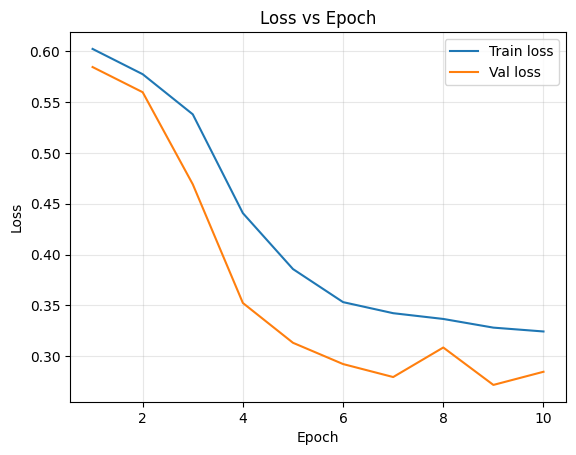

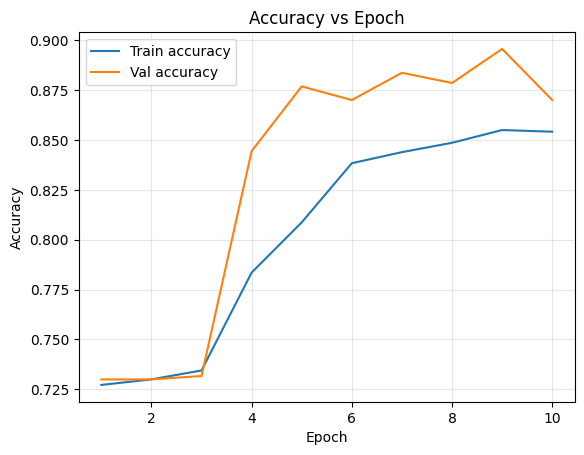

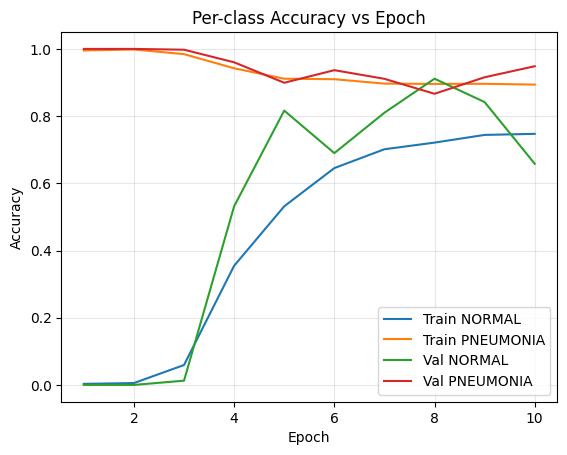

Model saved as 'chest_xray_model.pth'


In [22]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels, minlength=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

**Brief explanation of design choice of Baseline:**

The model was intentionally designed as a simple convolutional neural network to act as a baseline for binary chest X-ray classification. Two convolutional layers with small 3×3 kernels were used to extract low-level spatial features, with the number of channels increasing from 8 to 16 to allow slightly richer representations while keeping the model lightweight. ReLU activations introduce non-linearity and enable efficient gradient propagation, while max-pooling is applied after each convolution to reduce spatial resolution, lower computational cost, and provide a degree of translation invariance. An adaptive average pooling layer compresses the feature maps to a fixed-size representation independent of the input image resolution, simplifying the classifier design. The final classifier includes a small fully connected layer with dropout regularisation to mitigate overfitting before producing two logits corresponding to the normal and pneumonia classes.

**Results**

In [23]:
print("=== Baseline Validation Performance ===")
evaluate_model(model, val_loader, device)


=== Baseline Validation Performance ===
Accuracy : 0.8701
Precision: 0.8824
Recall   : 0.9485
F1-score : 0.9142
Confusion Matrix:
 [[104  54]
 [ 22 405]]


(0.8700854700854701,
 0.8823529411764706,
 0.9484777517564403,
 0.9142212189616253,
 array([[104,  54],
        [ 22, 405]]))

**Result discussion**

ADD HERE

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

**Improvement 1: Batch Normalisation**

Model 1 introduces Batch Normalisation as the first improvement over the baseline architecture. BatchNorm layers are inserted after each convolution, while all other aspects of the model are kept identical, including the number of convolutional layers, channel sizes, pooling strategy, and classifier structure. This controlled change ensures that any observed performance difference can be attributed solely to the inclusion of Batch Normalisation rather than an increase in model capacity. Batch Normalisation helps stabilise optimisation by normalising intermediate feature distributions, reducing internal covariate shift, and allowing more reliable gradient propagation during training. As a result, Model 1 is expected to converge more stably and generalise better than the baseline while maintaining the same overall complexity.

In [24]:
# Introduced BatchNorm to stabilise optimisation and improve generalisation.

class Model1_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


In [25]:
# Initialize the model
model_bn = Model1_BN().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bn.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_bn, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_bn.state_dict(), 'batch_norm_model.pth')
print("Model saved as 'batch_norm_model.pth'")

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.16it/s]



Epoch 1/10: train_loss=0.5132, train_acc=0.7447 | val_loss=0.3872, val_acc=0.7709
  Train class acc: NORMAL=0.205, PNEUMONIA=0.945
  Val   class acc: NORMAL=0.203, PNEUMONIA=0.981



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.30it/s]



Epoch 2/10: train_loss=0.3886, train_acc=0.8200 | val_loss=0.3395, val_acc=0.8325
  Train class acc: NORMAL=0.588, PNEUMONIA=0.906
  Val   class acc: NORMAL=0.437, PNEUMONIA=0.979



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.28it/s]



Epoch 3/10: train_loss=0.3647, train_acc=0.8316 | val_loss=0.3142, val_acc=0.8598
  Train class acc: NORMAL=0.660, PNEUMONIA=0.895
  Val   class acc: NORMAL=0.538, PNEUMONIA=0.979



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 4/10: train_loss=0.3466, train_acc=0.8482 | val_loss=0.3060, val_acc=0.8684
  Train class acc: NORMAL=0.722, PNEUMONIA=0.895
  Val   class acc: NORMAL=0.570, PNEUMONIA=0.979



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]



Epoch 5/10: train_loss=0.3459, train_acc=0.8503 | val_loss=0.3227, val_acc=0.8701
  Train class acc: NORMAL=0.731, PNEUMONIA=0.895
  Val   class acc: NORMAL=0.671, PNEUMONIA=0.944



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 6/10: train_loss=0.3329, train_acc=0.8518 | val_loss=0.2581, val_acc=0.8957
  Train class acc: NORMAL=0.741, PNEUMONIA=0.893
  Val   class acc: NORMAL=0.918, PNEUMONIA=0.888



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 7/10: train_loss=0.3277, train_acc=0.8555 | val_loss=0.2965, val_acc=0.8564
  Train class acc: NORMAL=0.746, PNEUMONIA=0.896
  Val   class acc: NORMAL=0.519, PNEUMONIA=0.981



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]



Epoch 8/10: train_loss=0.3277, train_acc=0.8548 | val_loss=0.3270, val_acc=0.8479
  Train class acc: NORMAL=0.735, PNEUMONIA=0.899
  Val   class acc: NORMAL=0.937, PNEUMONIA=0.815



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.30it/s]



Epoch 9/10: train_loss=0.3146, train_acc=0.8666 | val_loss=0.2406, val_acc=0.8957
  Train class acc: NORMAL=0.766, PNEUMONIA=0.904
  Val   class acc: NORMAL=0.835, PNEUMONIA=0.918



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.32it/s]


Epoch 10/10: train_loss=0.3060, train_acc=0.8666 | val_loss=0.2364, val_acc=0.9043
  Train class acc: NORMAL=0.777, PNEUMONIA=0.900
  Val   class acc: NORMAL=0.943, PNEUMONIA=0.890

Model saved as 'batch_norm_model.pth'


**Improvement 1: Batch Normalisation Results**

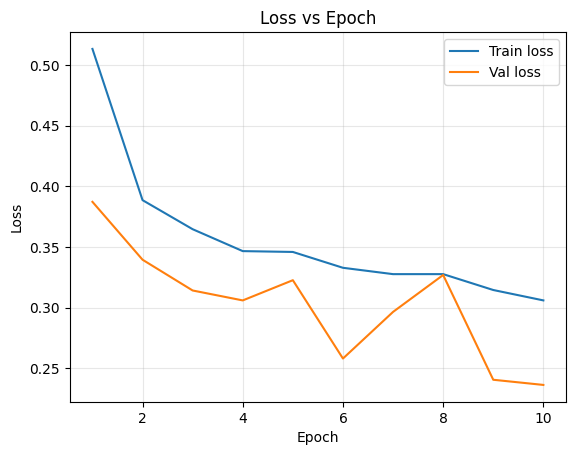

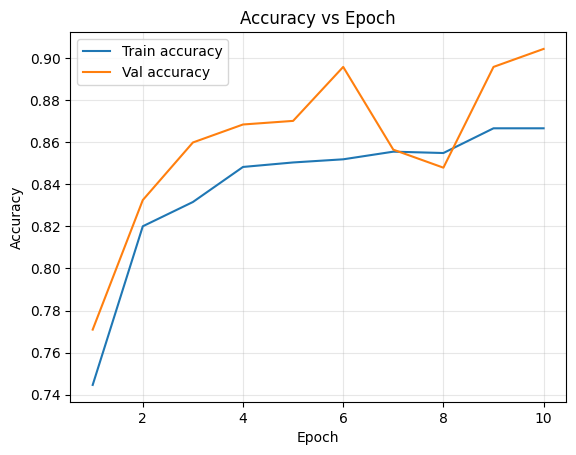

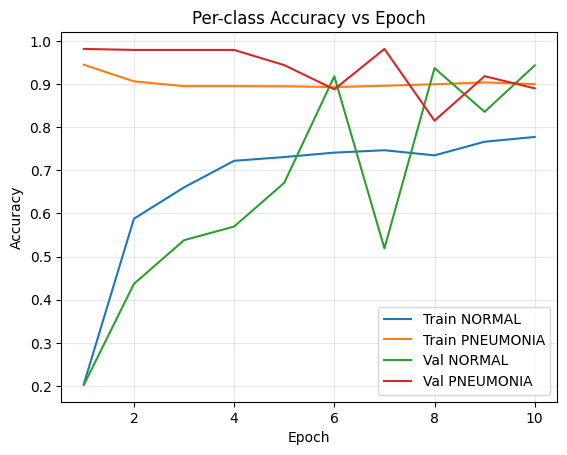

In [26]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [27]:
print("=== Batch Normalised Validation Performance ===")
evaluate_model(model_bn, val_loader, device)

=== Batch Normalised Validation Performance ===
Accuracy : 0.9043
Precision: 0.9769
Recall   : 0.8899
F1-score : 0.9314
Confusion Matrix:
 [[149   9]
 [ 47 380]]


(0.9042735042735043,
 0.9768637532133676,
 0.8899297423887588,
 0.9313725490196079,
 array([[149,   9],
        [ 47, 380]]))

**Improvement 1: Batch Normalisatio Discussion and Comparison to Baseline**

**Improvement 2: Adding Secound Convolution per Stage**

Model 2 builds upon Model 1 by introducing a third convolution blocks before each pooling operation, representing the second design improvement. Instead of applying a single convolution followed immediately by pooling, each stage now consists of two consecutive convolutional layers with Batch Normalisation and ReLU activations before downsampling. The number of stages and overall scale of the network remain modest, ensuring the model is still relatively small and comparable to earlier versions. This design allows the network to extract richer and more discriminative features at each spatial resolution before reducing spatial dimensionality. Any improvement in performance can therefore be attributed to enhanced feature extraction rather than simply increasing network size.

In [28]:
# Added a third convolution per stage to extract richer features before downsampling.

# Introduced BatchNorm to stabilise optimisation and improve generalisation.
class Model1_BN_3Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Conv 1
            nn.Conv2d(1, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Conv 2
            nn.Conv2d(8, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Conv 3 (NEW)
            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B, 32, 1, 1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 32),   # updated from 16 → 32
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


In [29]:
# Added another convolution per stage to extract richer features before downsampling.
# Initialize the model
model_3conv = Model1_BN_3Conv().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3conv.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_3conv, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_3conv.state_dict(), 'double_conv_model.pth')
print("Model saved as 'double_conv_model.pth'")


Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.32it/s]



Epoch 1/10: train_loss=0.4284, train_acc=0.7963 | val_loss=0.3886, val_acc=0.7983
  Train class acc: NORMAL=0.483, PNEUMONIA=0.912
  Val   class acc: NORMAL=0.278, PNEUMONIA=0.991



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]



Epoch 2/10: train_loss=0.3262, train_acc=0.8538 | val_loss=0.3123, val_acc=0.8479
  Train class acc: NORMAL=0.727, PNEUMONIA=0.901
  Val   class acc: NORMAL=0.905, PNEUMONIA=0.827



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.09it/s]



Epoch 3/10: train_loss=0.3103, train_acc=0.8634 | val_loss=0.2765, val_acc=0.8718
  Train class acc: NORMAL=0.756, PNEUMONIA=0.903
  Val   class acc: NORMAL=0.570, PNEUMONIA=0.984



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.19it/s]



Epoch 4/10: train_loss=0.2881, train_acc=0.8813 | val_loss=0.5316, val_acc=0.7419
  Train class acc: NORMAL=0.800, PNEUMONIA=0.911
  Val   class acc: NORMAL=0.994, PNEUMONIA=0.649



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 5/10: train_loss=0.2811, train_acc=0.8807 | val_loss=0.2087, val_acc=0.9128
  Train class acc: NORMAL=0.791, PNEUMONIA=0.914
  Val   class acc: NORMAL=0.968, PNEUMONIA=0.892



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.23it/s]



Epoch 6/10: train_loss=0.2700, train_acc=0.8930 | val_loss=0.3132, val_acc=0.8615
  Train class acc: NORMAL=0.800, PNEUMONIA=0.927
  Val   class acc: NORMAL=0.981, PNEUMONIA=0.817



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.19it/s]



Epoch 7/10: train_loss=0.2440, train_acc=0.9097 | val_loss=0.1761, val_acc=0.9248
  Train class acc: NORMAL=0.822, PNEUMONIA=0.942
  Val   class acc: NORMAL=0.835, PNEUMONIA=0.958



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 8/10: train_loss=0.2392, train_acc=0.9080 | val_loss=0.1321, val_acc=0.9487
  Train class acc: NORMAL=0.820, PNEUMONIA=0.941
  Val   class acc: NORMAL=0.956, PNEUMONIA=0.946



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 9/10: train_loss=0.2331, train_acc=0.9093 | val_loss=0.1330, val_acc=0.9556
  Train class acc: NORMAL=0.829, PNEUMONIA=0.939
  Val   class acc: NORMAL=0.861, PNEUMONIA=0.991



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.27it/s]


Epoch 10/10: train_loss=0.2364, train_acc=0.9076 | val_loss=0.1639, val_acc=0.9368
  Train class acc: NORMAL=0.821, PNEUMONIA=0.939
  Val   class acc: NORMAL=0.987, PNEUMONIA=0.918

Model saved as 'double_conv_model.pth'


**Improvement 2: Adding Convolution, Results**

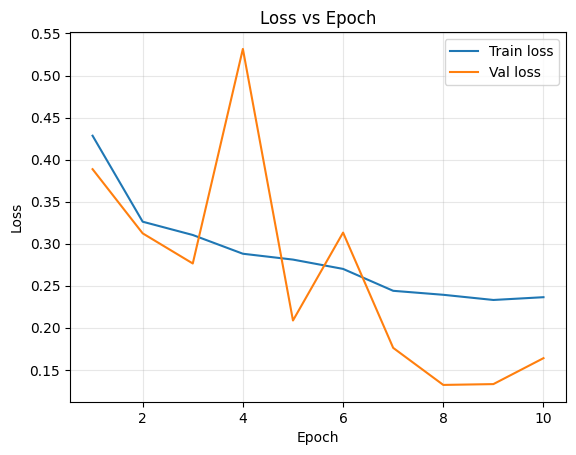

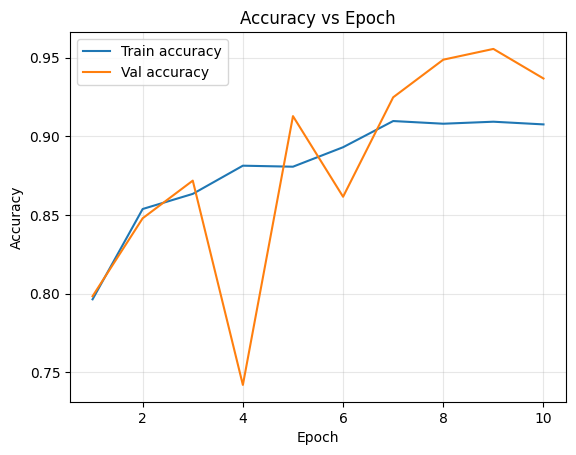

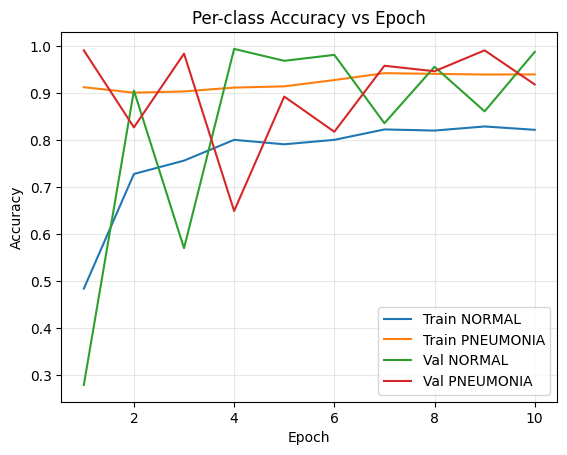

In [30]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [31]:
print("=== Double Convolution Validation Performance ===")
evaluate_model(model_3conv, val_loader, device)

=== Double Convolution Validation Performance ===
Accuracy : 0.9368
Precision: 0.9949
Recall   : 0.9180
F1-score : 0.9549
Confusion Matrix:
 [[156   2]
 [ 35 392]]


(0.9367521367521368,
 0.9949238578680203,
 0.9180327868852459,
 0.9549330085261876,
 array([[156,   2],
        [ 35, 392]]))

**Improvement 2: Adding Secound Convolution per Stage Discussion and Comparison to Baseline**



ADD HERE

**Improvement 3: Increased Multi-Scale Depth and Width**



The final model introduces the third and final improvement by expanding the network’s multi-scale depth and channel width. The same three convolution block design used in Model 2 is retained, but the architecture is scaled to four downsampling stages with progressively increasing channel sizes (32 → 64 → 128 → 256). This enables the model to learn hierarchical representations across multiple spatial scales, capturing both fine-grained local details and higher-level global structures present in chest X-ray images. While SiLU activations are used in this model, they are treated as part of the final block implementation rather than a separate design choice. This final expansion significantly increases representational capacity and allows the network to model complex patterns more effectively.

In [ ]:

class FinalModel(nn.Module):
    def __init__(self):
        super().__init__()

        def stage(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),  # ✅ third conv
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 32),    # 128 -> 64
            block(32, 64),   # 64  -> 32
            block(64, 128),  # 32  -> 16
            block(128, 256), # 16  -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


In [33]:
# Expanded the network to learn multi-scale representations by adding additional downsampling stages and increasing channel width.

# Initialize the model
model_final = FinalModel().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_final.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_final, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_final.state_dict(), 'final_model.pth')
print("Model saved as 'final_model.pth'")

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 1/10: train_loss=0.3039, train_acc=0.8668 | val_loss=0.5012, val_acc=0.7607
  Train class acc: NORMAL=0.730, PNEUMONIA=0.917
  Val   class acc: NORMAL=0.918, PNEUMONIA=0.703



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.29it/s]



Epoch 2/10: train_loss=0.2347, train_acc=0.9101 | val_loss=0.3260, val_acc=0.8650
  Train class acc: NORMAL=0.814, PNEUMONIA=0.946
  Val   class acc: NORMAL=0.994, PNEUMONIA=0.817



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.29it/s]



Epoch 3/10: train_loss=0.1992, train_acc=0.9219 | val_loss=0.1056, val_acc=0.9692
  Train class acc: NORMAL=0.835, PNEUMONIA=0.954
  Val   class acc: NORMAL=0.911, PNEUMONIA=0.991



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 4/10: train_loss=0.1830, train_acc=0.9319 | val_loss=0.3052, val_acc=0.8667
  Train class acc: NORMAL=0.855, PNEUMONIA=0.960
  Val   class acc: NORMAL=0.506, PNEUMONIA=1.000



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 5/10: train_loss=0.1984, train_acc=0.9216 | val_loss=0.0994, val_acc=0.9761
  Train class acc: NORMAL=0.831, PNEUMONIA=0.955
  Val   class acc: NORMAL=0.930, PNEUMONIA=0.993



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.19it/s]



Epoch 6/10: train_loss=0.1664, train_acc=0.9400 | val_loss=0.2625, val_acc=0.8923
  Train class acc: NORMAL=0.863, PNEUMONIA=0.968
  Val   class acc: NORMAL=0.601, PNEUMONIA=1.000



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.12it/s]



Epoch 7/10: train_loss=0.1637, train_acc=0.9370 | val_loss=0.1514, val_acc=0.9419
  Train class acc: NORMAL=0.861, PNEUMONIA=0.965
  Val   class acc: NORMAL=0.791, PNEUMONIA=0.998



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 8/10: train_loss=0.1486, train_acc=0.9436 | val_loss=0.1853, val_acc=0.9231
  Train class acc: NORMAL=0.885, PNEUMONIA=0.965
  Val   class acc: NORMAL=0.715, PNEUMONIA=1.000



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.16it/s]



Epoch 9/10: train_loss=0.1489, train_acc=0.9456 | val_loss=0.1017, val_acc=0.9624
  Train class acc: NORMAL=0.874, PNEUMONIA=0.972
  Val   class acc: NORMAL=0.937, PNEUMONIA=0.972



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]


Epoch 10/10: train_loss=0.1454, train_acc=0.9503 | val_loss=0.0889, val_acc=0.9675
  Train class acc: NORMAL=0.887, PNEUMONIA=0.974
  Val   class acc: NORMAL=0.956, PNEUMONIA=0.972

Model saved as 'final_model.pth'


**Improvement 3: Increased Multi-Scale Depth and Width, Results**

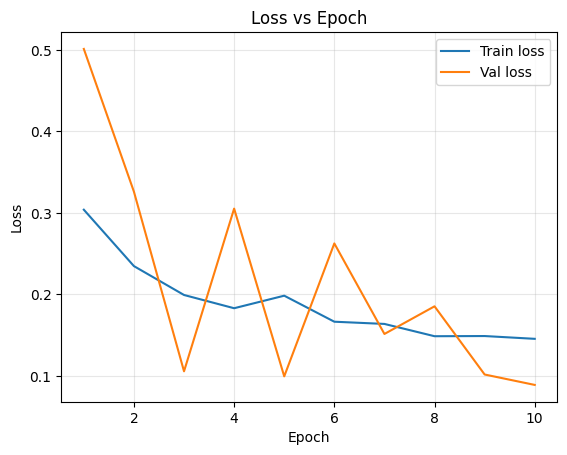

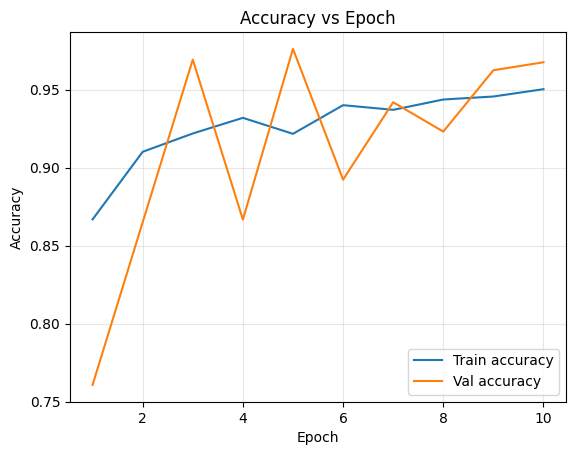

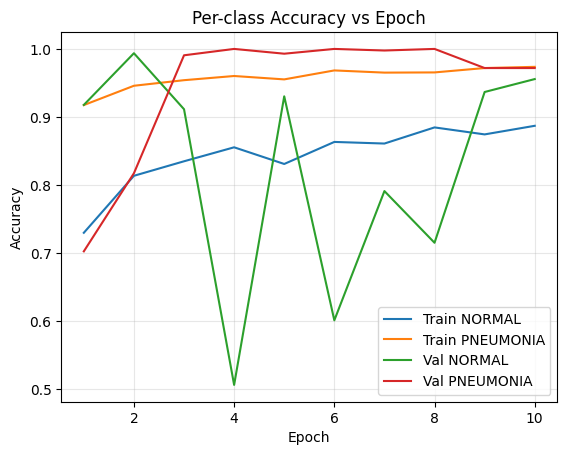

In [34]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [35]:
print("=== Final Model Validation Performance ===")
evaluate_model(model_final, val_loader, device)

=== Final Model Validation Performance ===
Accuracy : 0.9675
Precision: 0.9834
Recall   : 0.9719
F1-score : 0.9776
Confusion Matrix:
 [[151   7]
 [ 12 415]]


(0.9675213675213675,
 0.9834123222748815,
 0.9718969555035128,
 0.9776207302709069,
 array([[151,   7],
        [ 12, 415]]))

**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*


**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

**(c)**

_Discuss your results here_

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


In [36]:
# No third convolutional Layer
class Emp1(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 32),    # 128 -> 64
            block(32, 64),   # 64  -> 32
            block(64, 128),  # 32  -> 16
            block(128, 256), # 16  -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B, 256, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

In [37]:
#No third Convolutional layer (Batch normalisation + increased multi scale width)
# Initialize the model
model_emp1 = Emp1().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emp1.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_emp1, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_emp1.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.11it/s]



Epoch 1/10: train_loss=0.3159, train_acc=0.8567 | val_loss=0.2514, val_acc=0.9094
  Train class acc: NORMAL=0.737, PNEUMONIA=0.901
  Val   class acc: NORMAL=0.734, PNEUMONIA=0.974



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.07it/s]



Epoch 2/10: train_loss=0.2444, train_acc=0.9041 | val_loss=0.1631, val_acc=0.9350
  Train class acc: NORMAL=0.805, PNEUMONIA=0.941
  Val   class acc: NORMAL=0.930, PNEUMONIA=0.937



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.23it/s]



Epoch 3/10: train_loss=0.2150, train_acc=0.9187 | val_loss=0.2443, val_acc=0.9060
  Train class acc: NORMAL=0.823, PNEUMONIA=0.954
  Val   class acc: NORMAL=0.987, PNEUMONIA=0.876



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 4/10: train_loss=0.2041, train_acc=0.9216 | val_loss=0.1344, val_acc=0.9402
  Train class acc: NORMAL=0.834, PNEUMONIA=0.954
  Val   class acc: NORMAL=0.962, PNEUMONIA=0.932



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.20it/s]



Epoch 5/10: train_loss=0.1873, train_acc=0.9236 | val_loss=0.1031, val_acc=0.9607
  Train class acc: NORMAL=0.837, PNEUMONIA=0.956
  Val   class acc: NORMAL=0.956, PNEUMONIA=0.963



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]



Epoch 6/10: train_loss=0.1719, train_acc=0.9379 | val_loss=0.1158, val_acc=0.9590
  Train class acc: NORMAL=0.876, PNEUMONIA=0.961
  Val   class acc: NORMAL=0.873, PNEUMONIA=0.991



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 7/10: train_loss=0.1713, train_acc=0.9385 | val_loss=0.1256, val_acc=0.9521
  Train class acc: NORMAL=0.869, PNEUMONIA=0.964
  Val   class acc: NORMAL=0.962, PNEUMONIA=0.948



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 8/10: train_loss=0.1663, train_acc=0.9340 | val_loss=0.0971, val_acc=0.9744
  Train class acc: NORMAL=0.852, PNEUMONIA=0.964
  Val   class acc: NORMAL=0.924, PNEUMONIA=0.993



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.06it/s]



Epoch 9/10: train_loss=0.1509, train_acc=0.9415 | val_loss=0.1112, val_acc=0.9607
  Train class acc: NORMAL=0.867, PNEUMONIA=0.969
  Val   class acc: NORMAL=0.968, PNEUMONIA=0.958



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]


Epoch 10/10: train_loss=0.1606, train_acc=0.9387 | val_loss=0.0900, val_acc=0.9658
  Train class acc: NORMAL=0.865, PNEUMONIA=0.966
  Val   class acc: NORMAL=0.892, PNEUMONIA=0.993

Model saved as 'chest_xray_model.pth'


**(a)**

Here the third convolutional layer is missing.

**Results**

_Present your results, including plots etc, here_

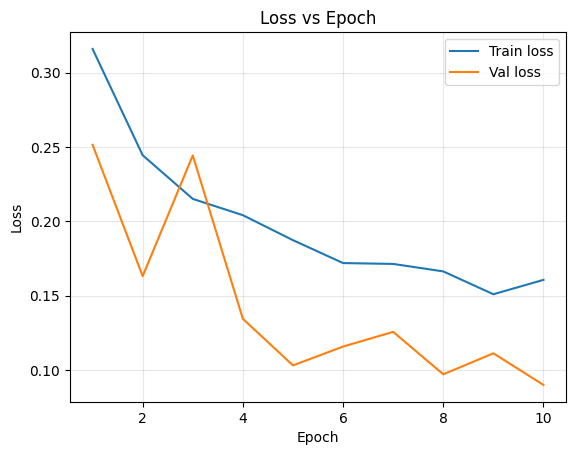

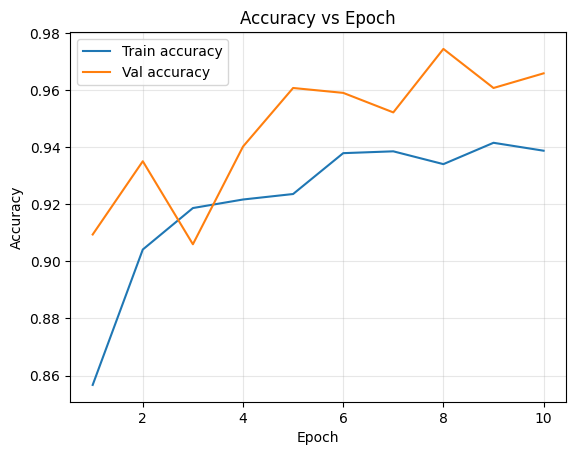

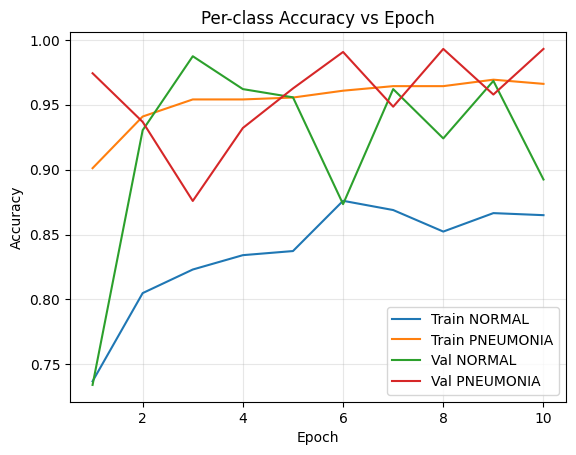

In [38]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [39]:
print("=== Emrprical Model 1 Validation Performance ===")
evaluate_model(model_emp1, val_loader, device)

=== Emrprical Model 1 Validation Performance ===
Accuracy : 0.9658
Precision: 0.9615
Recall   : 0.9930
F1-score : 0.9770
Confusion Matrix:
 [[141  17]
 [  3 424]]


(0.9658119658119658,
 0.9614512471655329,
 0.9929742388758782,
 0.9769585253456221,
 array([[141,  17],
        [  3, 424]]))

**(c)**

_Discuss your results here_

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [40]:

class Emp2(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 16),   # slightly wider than baseline
            block(16, 32),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

In [41]:
# Initialize the model
model_emp2 = Emp2().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emp2.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_emp2, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_emp2.state_dict(), 'double_conv_model.pth')
print("Model saved as 'double_conv_model.pth'")


Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.05it/s]



Epoch 1/10: train_loss=0.3806, train_acc=0.8162 | val_loss=0.6772, val_acc=0.7333
  Train class acc: NORMAL=0.552, PNEUMONIA=0.914
  Val   class acc: NORMAL=0.013, PNEUMONIA=1.000



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.09it/s]



Epoch 2/10: train_loss=0.3117, train_acc=0.8670 | val_loss=0.2273, val_acc=0.9043
  Train class acc: NORMAL=0.764, PNEUMONIA=0.905
  Val   class acc: NORMAL=0.924, PNEUMONIA=0.897



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 3/10: train_loss=0.2780, train_acc=0.8890 | val_loss=0.1916, val_acc=0.9368
  Train class acc: NORMAL=0.806, PNEUMONIA=0.920
  Val   class acc: NORMAL=0.911, PNEUMONIA=0.946



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 4/10: train_loss=0.2671, train_acc=0.8888 | val_loss=0.2035, val_acc=0.9162
  Train class acc: NORMAL=0.801, PNEUMONIA=0.921
  Val   class acc: NORMAL=0.709, PNEUMONIA=0.993



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 5/10: train_loss=0.2490, train_acc=0.8984 | val_loss=0.3103, val_acc=0.8650
  Train class acc: NORMAL=0.817, PNEUMONIA=0.929
  Val   class acc: NORMAL=0.506, PNEUMONIA=0.998



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.12it/s]



Epoch 6/10: train_loss=0.2239, train_acc=0.9157 | val_loss=0.1369, val_acc=0.9556
  Train class acc: NORMAL=0.835, PNEUMONIA=0.946
  Val   class acc: NORMAL=0.975, PNEUMONIA=0.948



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.08it/s]



Epoch 7/10: train_loss=0.2182, train_acc=0.9140 | val_loss=0.1043, val_acc=0.9692
  Train class acc: NORMAL=0.836, PNEUMONIA=0.943
  Val   class acc: NORMAL=0.943, PNEUMONIA=0.979



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.08it/s]



Epoch 8/10: train_loss=0.2016, train_acc=0.9227 | val_loss=0.1213, val_acc=0.9573
  Train class acc: NORMAL=0.853, PNEUMONIA=0.949
  Val   class acc: NORMAL=0.968, PNEUMONIA=0.953



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 9/10: train_loss=0.2064, train_acc=0.9259 | val_loss=0.1044, val_acc=0.9658
  Train class acc: NORMAL=0.856, PNEUMONIA=0.952
  Val   class acc: NORMAL=0.937, PNEUMONIA=0.977



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.10it/s]


Epoch 10/10: train_loss=0.1870, train_acc=0.9291 | val_loss=0.1070, val_acc=0.9709
  Train class acc: NORMAL=0.859, PNEUMONIA=0.955
  Val   class acc: NORMAL=0.981, PNEUMONIA=0.967

Model saved as 'double_conv_model.pth'


**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

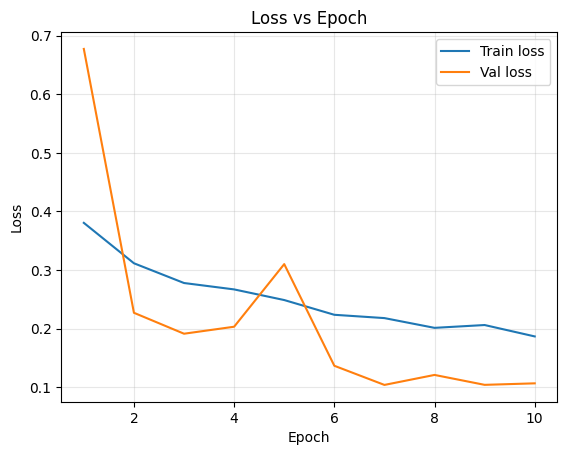

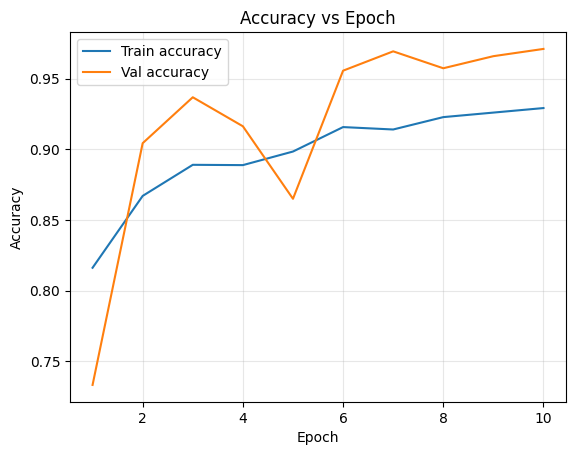

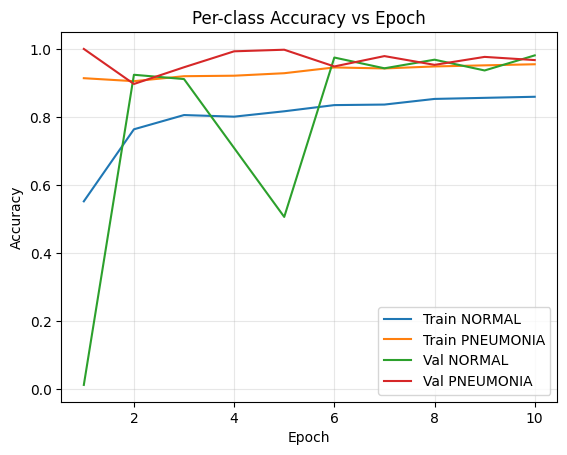

In [42]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [43]:
print("=== Emprical Improvement 2 Validation Performance ===")
evaluate_model(model_emp2, val_loader, device)

=== Emprical Improvement 2 Validation Performance ===
Accuracy : 0.9709
Precision: 0.9928
Recall   : 0.9672
F1-score : 0.9798
Confusion Matrix:
 [[155   3]
 [ 14 413]]


(0.9709401709401709,
 0.9927884615384616,
 0.9672131147540983,
 0.9798339264531435,
 array([[155,   3],
        [ 14, 413]]))

**(c)**

_Discuss your results here_

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [44]:
# No Triple Convolution Layers (Improvements Batch Normalisation and Multi-Scale Representation)

class Emp3(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 32),    # 128 -> 64
            block(32, 64),   # 64  -> 32
            block(64, 128),  # 32  -> 16
            block(128, 256), # 16  -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B, 256, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


In [45]:
# Initialize the model
model_emp3 = Emp3().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emp3.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model_emp3, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model_emp3.state_dict(), 'emp_3.pth')
print("Model saved as 'emp_3.pth'")


Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.12it/s]



Epoch 1/10: train_loss=0.3121, train_acc=0.8544 | val_loss=0.4233, val_acc=0.8017
  Train class acc: NORMAL=0.716, PNEUMONIA=0.906
  Val   class acc: NORMAL=0.266, PNEUMONIA=1.000



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.23it/s]



Epoch 2/10: train_loss=0.2400, train_acc=0.9033 | val_loss=0.1281, val_acc=0.9521
  Train class acc: NORMAL=0.806, PNEUMONIA=0.939
  Val   class acc: NORMAL=0.880, PNEUMONIA=0.979



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.14it/s]



Epoch 3/10: train_loss=0.2124, train_acc=0.9178 | val_loss=0.2031, val_acc=0.9299
  Train class acc: NORMAL=0.837, PNEUMONIA=0.948
  Val   class acc: NORMAL=0.975, PNEUMONIA=0.913



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]



Epoch 4/10: train_loss=0.1988, train_acc=0.9238 | val_loss=0.1133, val_acc=0.9607
  Train class acc: NORMAL=0.848, PNEUMONIA=0.952
  Val   class acc: NORMAL=0.886, PNEUMONIA=0.988



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.17it/s]



Epoch 5/10: train_loss=0.1862, train_acc=0.9313 | val_loss=0.1105, val_acc=0.9641
  Train class acc: NORMAL=0.849, PNEUMONIA=0.962
  Val   class acc: NORMAL=0.981, PNEUMONIA=0.958



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.11it/s]



Epoch 6/10: train_loss=0.1713, train_acc=0.9342 | val_loss=0.1098, val_acc=0.9675
  Train class acc: NORMAL=0.866, PNEUMONIA=0.960
  Val   class acc: NORMAL=0.975, PNEUMONIA=0.965



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.02it/s]



Epoch 7/10: train_loss=0.1627, train_acc=0.9421 | val_loss=0.0953, val_acc=0.9692
  Train class acc: NORMAL=0.869, PNEUMONIA=0.969
  Val   class acc: NORMAL=0.924, PNEUMONIA=0.986



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.18it/s]



Epoch 8/10: train_loss=0.1614, train_acc=0.9413 | val_loss=0.1421, val_acc=0.9521
  Train class acc: NORMAL=0.868, PNEUMONIA=0.968
  Val   class acc: NORMAL=0.987, PNEUMONIA=0.939



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.10it/s]



Epoch 9/10: train_loss=0.1466, train_acc=0.9460 | val_loss=0.3617, val_acc=0.8598
  Train class acc: NORMAL=0.885, PNEUMONIA=0.968
  Val   class acc: NORMAL=0.481, PNEUMONIA=1.000



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]


Epoch 10/10: train_loss=0.1522, train_acc=0.9430 | val_loss=0.1161, val_acc=0.9675
  Train class acc: NORMAL=0.878, PNEUMONIA=0.967
  Val   class acc: NORMAL=0.981, PNEUMONIA=0.963

Model saved as 'emp_3.pth'


**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

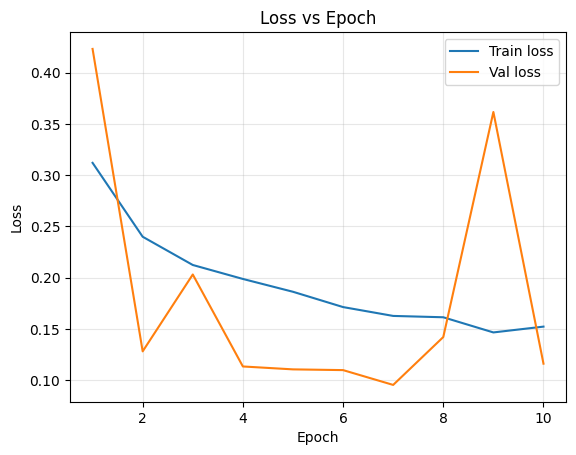

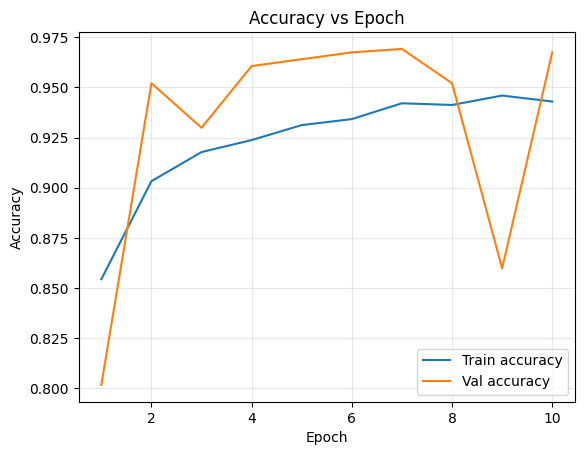

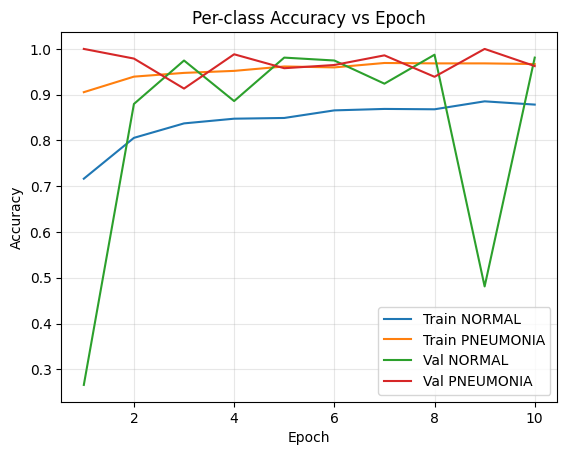

In [46]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [47]:
print("=== Emprical Improvement 3 Validation Performance ===")
evaluate_model(model_emp3, val_loader, device)

=== Emprical Improvement 3 Validation Performance ===
Accuracy : 0.9675
Precision: 0.9928
Recall   : 0.9625
F1-score : 0.9774
Confusion Matrix:
 [[155   3]
 [ 16 411]]


(0.9675213675213675,
 0.9927536231884058,
 0.9625292740046838,
 0.9774078478002378,
 array([[155,   3],
        [ 16, 411]]))

**(c)**

_Discuss your results here_

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [48]:

def final_evaluate(model, dataloader, device, criterion=None):
    model.eval()

    total_loss, total_n = 0.0, 0
    y_true_list, y_pred_list, y_prob_list = [], [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            logits = model(x)                       # (B,2)
            probs = torch.softmax(logits, dim=1)     # (B,2)
            pred = probs.argmax(dim=1)              # (B,)
            prob_pos = probs[:, 1]                  # P(class=1)

            if criterion is not None:
                loss = criterion(logits, y)
                bs = x.size(0)
                total_loss += loss.item() * bs
                total_n += bs

            y_true_list.append(y.cpu().numpy())
            y_pred_list.append(pred.cpu().numpy())
            y_prob_list.append(prob_pos.cpu().numpy())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    y_prob = np.concatenate(y_prob_list)

    # Confusion matrix (binary): [[TN, FP], [FN, TP]]
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    cm = np.array([[tn, fp],
                   [fn, tp]])

    # Core metrics
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-12)

    precision_pos = tp / (tp + fp + 1e-12)
    recall_pos    = tp / (tp + fn + 1e-12)
    f1_pos        = 2 * precision_pos * recall_pos / (precision_pos + recall_pos + 1e-12)

    # Class-0 metrics (treat class 0 as "positive" for reporting)
    precision_0 = tn / (tn + fn + 1e-12)
    recall_0    = tn / (tn + fp + 1e-12)
    f1_0        = 2 * precision_0 * recall_0 / (precision_0 + recall_0 + 1e-12)

    macro_f1 = 0.5 * (f1_0 + f1_pos)

    avg_loss = (total_loss / (total_n + 1e-12)) if criterion is not None else None

    # ROC-AUC and PR-AUC (implemented without sklearn)
    def roc_auc_score_np(y, s):
        order = np.argsort(-s)
        y = y[order]
        P = np.sum(y == 1)
        N = np.sum(y == 0)
        if P == 0 or N == 0:
            return np.nan
        tps = np.cumsum(y == 1)
        fps = np.cumsum(y == 0)
        tpr = tps / (P + 1e-12)
        fpr = fps / (N + 1e-12)
        return np.trapezoid(tpr, fpr)

    def pr_auc_score_np(y, s):
        order = np.argsort(-s)
        y = y[order]
        P = np.sum(y == 1)
        if P == 0:
            return np.nan
        tps = np.cumsum(y == 1)
        fps = np.cumsum(y == 0)
        precision = tps / (tps + fps + 1e-12)
        recall = tps / (P + 1e-12)
        return np.trapezoid(precision, recall)

    roc_auc = roc_auc_score_np(y_true, y_prob)
    pr_auc  = pr_auc_score_np(y_true, y_prob)

    print("=== Final Evaluation (Test Set) ===")
    if avg_loss is not None:
        print(f"Loss        : {avg_loss:.4f}")
    print(f"Accuracy    : {acc:.4f}")
    print(f"F1 (class 1): {f1_pos:.4f} | Precision: {precision_pos:.4f} | Recall: {recall_pos:.4f}")
    print(f"F1 (class 0): {f1_0:.4f}   | Precision: {precision_0:.4f} | Recall: {recall_0:.4f}")
    print(f"Macro-F1    : {macro_f1:.4f}")
    print(f"ROC-AUC     : {roc_auc:.4f}")
    print(f"PR-AUC      : {pr_auc:.4f}")
    print("Confusion Matrix:\n", cm)

    return {
        "loss": avg_loss,
        "acc": acc,
        "precision_1": precision_pos,
        "recall_1": recall_pos,
        "f1_1": f1_pos,
        "precision_0": precision_0,
        "recall_0": recall_0,
        "f1_0": f1_0,
        "macro_f1": macro_f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }


In [49]:

results = final_evaluate(model_final, test_loader, device, criterion=criterion)


=== Final Evaluation (Test Set) ===
Loss        : 0.1701
Accuracy    : 0.9370
F1 (class 1): 0.9566 | Precision: 0.9600 | Recall: 0.9533
F1 (class 0): 0.8847   | Precision: 0.8765 | Recall: 0.8931
Macro-F1    : 0.9207
ROC-AUC     : 0.9787
PR-AUC      : 0.9887
Confusion Matrix:
 [[142  17]
 [ 20 408]]


**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_